In [1]:
""" ---------------- """
"""    The Basics    """ 
""" ---------------- """

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import time
import os
import csv
import json
import shutil
import re

from IPython.display import display, clear_output
import cv2
import pandas as pd
from scipy.signal import find_peaks

import pyautogui
import mne

from importlib import reload
import conditions

%matplotlib inline


""" ---------------------- """
"""    HELPER FUNCTIONS    """
""" ---------------------- """

def flatten(L):
  for item in L:
    try:
      yield from flatten(item)
    except TypeError:
      yield item

# Src of Function: https://stackoverflow.com/questions/24005221/ipython-notebook-early-exit-from-cell
class StopExecution(Exception):
  def _render_traceback_(self):
    return []

def InchToPixel(inches):
  return int(inches * 96)

# These three functions sort filenames "humanly" (as opposed to the default lexicographical sorting that computers understand)
# The user-friendly function to use is `sort_nicely(l)`, where `l` is a list of files where all contents are of type ____<#>.png
# Source: https://nedbatchelder.com/blog/200712/human_sorting.html
def tryint(s):
    try:
        return int(s)
    except:
        return s
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks. "z23a" -> ["z", 23, "a"] """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]
def sort_nicely(l):
   return sorted(l, key=alphanum_key) 

C:\Users\chenw\AppData\Local\Temp\ipykernel_2484\1086508340.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
""" --------------------- """
"""    HYPERPARAMETERS    """
""" --------------------- """

_REFERENCE_CHANNELS = ["TP9","TP10"]   # Which channels should we re-reference the EEG data to?
_FREQUENCY_CHANNELS = ["AF7", "AF8"]   # Which channels are we interested in observing specifically?
_FREQUENCY_RANGE = (0.5, 80)           # What frequency will we bandpass filter for?
_POWER_RANGE = (0, 200)                # What is the power range of the Power Spectral Density graph that'll be produced? Purely visual in function
_PSD_AVG = "mean"                      # When calculating the Power Spectral Density, what metric should we aggregate data samples around?
_FIGSIZE = (10, 5)                     # When producing the PSD graph, what will the figure size be? Purely visual in function
_CHANNEL_COLORS = ["blue", "red"]      # When producing the PSD graph, what colors correspond to the channels in _FREQUENCY_CHANNELS? Purely visual in function
_SAVE_CSV = True                       # Should we save the raw EEG data as well as the processed data?
_VERBOSE = False                       # Should we be verbose and yell at the user about warnings, update messages, print statements, etc?

""" ========================================================================
THE FOLLOWING ARE NOT HYPERPARAMETERS AND MUST NOT BE ALTERED IN ANY WAY
======================================================================== """

frequency_bands = {
  "delta": {"range":(0.5,4),"color":"darkgray"},
  "theta": {"range":(4, 8),"color":"lightblue"},
  "alpha": {"range":(8, 16),"color":"blue"},
  "beta":  {"range":(16, 32),"color":"orange"},
  "gamma": {"range":(32, 80),"color":"red"}   
}

In [3]:
class EEGInterpreter:
  def __init__(self,
      name,
      filename,
      timestamp_col="unix_ts",
      drop_channels=['ch5'],
      relabel={'ch1':'TP9', 'ch2':'AF7', 'ch3':'AF8', 'ch4':'TP10'},
      min_freq=None,
      max_freq=None,
      verbose=False
               ):
    self.name = name
    self.raw = pd.read_csv(filename)
    self.signal_labels = ['TP9','TP10','AF7', 'AF8']

    if drop_channels is not None:
      self.raw = self.raw.drop(columns=drop_channels).drop_duplicates()
    else:
      self.raw = self.raw.drop_duplicates()

    if relabel is not None:
      self.raw.rename(columns={'ch1':'TP9', 'ch2':'AF7', 'ch3':'AF8', 'ch4':'TP10'}, inplace=True)

    # Get some statistics regarding our data
    self.unix_start = self.raw.iloc[0][timestamp_col]
    self.unix_end = self.raw.iloc[-1][timestamp_col]
    self.duration = self.unix_end - self.unix_start
    self.size = len(self.raw.index)
    self.frequency = round(self.size / self.duration)
    
    # Copy the data to prevent mutation
    self.eeg = self.raw.copy(deep=True)
    if verbose: self.PrintEEGHead()
  
    # Calcualte the muse info, mne, and initialize the psd
    muse2_info = mne.create_info(["TP9","TP10","AF7", "AF8"], self.frequency, ch_types='eeg', verbose=verbose)      
    s_array = np.transpose(self.eeg[["TP9", "TP10", "AF7", "AF8"]].to_numpy())
    self.mne = mne.io.RawArray(s_array, muse2_info, first_samp=0, copy='auto', verbose=verbose)
    self.psd = None

    # Filter based on frequency range if provided
    if min_freq is not None or max_freq is not None:
      self.mne.filter(min_freq, max_freq, verbose=verbose)

  def ReReference(self, new_refs=['TP9', 'TP10']):
    self.mne.set_eeg_reference(ref_channels=new_refs)

  def ComputePSD(self, tmin=None, tmax=None, average="mean"):
    self.psd = self.mne.compute_psd(tmin=tmin, tmax=tmax, average=average)

  def PrintEEGHead(self, n=10):
    display(self.eeg.head(n))
  def PlotEEG(self, scaling="auto"):
    self.mne.plot(scalings=scaling)

  def PlotPSD(self):
    if self.psd is None:
      print("ERROR: PSD not calculated yet!")
      return
    self.psd.plot(picks=["AF7","AF8"])

  def PlotPSDGantt(self,
                  channels=["AF7", "AF8"],
                  start=None,
                  end=None,
                  dt=1.0,
                  average="mean",
                  fmin=None,
                  fmax=None,
                  frequencies=["alpha","beta","gamma"],
                  colors=["blue","red","orange"],
                  title=None,
                  figsize=(10,4),
                  peak_threshold=None,
                  representative_metric="max",
                  events=None,
                  save_fig_filename=False
                    ):
    
    # Reload the conditions to reset colors
    reload(conditions)
    
    # Initialize our figure
    fig, ax = plt.subplots(1,1,figsize=figsize)
    t = title if title is not None else f"{self.name} \n[dt: {dt}]"
    plt.title(t)
    if fmin is not None:
      plt.ylim(bottom=fmin)
    if fmax is not None:
      plt.ylim(top=fmax)
    
    ax.set_xlabel(f"Time (Seconds, dt = {dt} sec.)")
    ax.set_ylabel("Frequency (Hz)")
    handles, labels = plt.gca().get_legend_handles_labels()
    added_labels = []
    
    # If we want to save a figure, but it exists, let's delete it
    if save_fig_filename is not None and os.path.exists(save_fig_filename):
      os.remove(save_fig_filename)
      
    # Initialize our data arrays
    x = []
    y = {}
    for freq in frequencies:
      y[freq] = []
    
    # Iterate through each epoch
    s = start if start is not None else 0
    e = end if end is not None else self.duration
    for tmin in np.arange(s, e, dt):
      
      # Add the current timestamp `tmin` to `x`
      x.append(tmin)
      
      # Calculate the timespan, psd from that timespan, and the powers/frequencies in that timespan
      tmax = tmin + dt
      if tmax > e: break
      try:
        psd = self.mne.compute_psd(tmin=tmin, tmax=tmax, average=average, verbose=False)
        powers, freqs = psd.get_data(picks=channels, return_freqs=True)
      
        # powers is a multidimensional list; freqs is not
        # freqs is technically the x-axis; powers[i] is the data for each channel "AF7", "AF8", etc.
        # We need to calculate the peaks for each channel
        peak_freqs = {}
        peak_powers = {}
        for freq in frequencies:
          peak_freqs[freq] = []
          peak_powers[freq] = []
        
        if len(powers) > 0:
          for i in range(len(channels)):
            # calc peaks for this channel
            peaks, _ = find_peaks(powers[i], threshold=peak_threshold)
            # `peaks` is a list of indices. 
            # To get the corresponding frequencies and powers, we need to call `freqs[peaks]` and `powers[i][peaks]`
            # We need to separate each peak and determine which frequency band they are in
            for peak in peaks:
              peak_freq = freqs[peak]
              peak_power = powers[i][peak]
              for freq in frequencies:
                if peak_freq >= frequency_bands[freq]["range"][0] and peak_freq < frequency_bands[freq]["range"][1]:
                  # this peak is inside this frequency band.
                  peak_freqs[freq].append(peak_freq)
                  peak_powers[freq].append(peak_power)
      
          # Now, peak_freqs contains the frequencies corresponding to each frequency band
          # Similarly, peak_powers contains the powers corresponding to each frequency band
          # Now, the last thing to do is, for each frequency band, determine the representative peak
          # This is merely the max peak detected
          for freq in frequencies:
            if len(peak_powers[freq]) > 0:
              if representative_metric == "mean":
                y[freq].append(np.mean(peak_freqs[freq]))
              else:
                max_peak_index = np.argmax(peak_powers[freq])
                y[freq].append(peak_freqs[freq][max_peak_index])
            else:
              y[freq].append(0)
      
          # once we end the `tmin` loop, we should have:
          # `x`: the time series
          # `y`: a dictionary for each frequency- each frequency has the same length as `x`
          # We just need to plot
          for i in range(len(frequencies)):
            freq = frequencies[i]
            col = colors[i]
            plt.plot(x, y[freq], label=freq, color=col)
            if freq in added_labels: continue
            event_line = Line2D([0], [0], label=freq, color=col)
            handles.extend([event_line])
            added_labels.append(freq)
            
      except:
        print("No EEG data detected")
        break
      
    # OPTIONAL: if provide events, we can begin to give more details
    
    if events is not None:
      # For now, we'll just print the position data
      positions = events.GetPositions(tmin=s, tmax=e, dt=dt)
      # Each position is, thankfully, already tagged with `rel_start` and `rel_end` and "label"
      # which tells us the relative start and ends based on the beginning of the VR session
      # All we need to do is plot axvspans between these ranges
      for pos in positions:
        col = conditions.label_color_map[pos["label"]]
        plt.axvspan(pos["rel_start"], pos["rel_end"], color=col.color, alpha=col.alpha)
        if pos["label"] in added_labels: continue
        event_line = Line2D([0], [0], label=pos["label"], color=col.color)
        handles.extend([event_line])
        added_labels.append(pos["label"])

    # Add a legend
    plt.legend(handles=handles)
    
    # If indicated, save the fig
    if save_fig_filename is not None:
      plt.savefig(save_fig_filename, bbox_inches="tight")
    
    # Show the plt
    plt.show()

  def PlotPSDOverTime(self,
                      channels=["AF7","AF8"],
                      start=None,
                      end=None,
                      dt=1.0,
                      average="mean",
                      pmax=None,
                      auto_pmax=True,
                      render_dt=0.1,
                      frequencies=None,
                      title=None,
                      figsize=(10,4),
                      colors=["blue","red"],
                      detect_peaks=False,
                      peak_threshold=None,
                      events=None,
                      save_video_filepath=None,
                      delete_video_frames=True
                        ):
    
    # Reload the conditions to reset colors
    reload(conditions)
    
    # We need to grab the first and last timestamp of our data, as well as our duration
    first_timestamp = self.raw.iloc[0]["lsl_ts"]
    last_timestamp = self.raw.iloc[-1]["lsl_ts"]
    total_time = last_timestamp - first_timestamp

    # Initialize the figure
    #t = title if title is not None else self.name
    hdisplay = display("", display_id=True)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel('Frequency (Hz)')
    
    # IF we're saving a video, then we'll need to initialize an array to store the generated images
    # We'll e using `render_dt` as the interval for each frame in the video
    if save_video_filepath is not None:
      video_dirname = os.path.dirname(save_video_filepath)+'/temp/'
      # We go on a bit of a file-killer spree. If the directory already exists, we have to terminate it early. Then we can create our own temp folder
      if os.path.exists(video_dirname):
        shutil.rmtree(video_dirname)
      os.makedirs(video_dirname)
      # If a video with the same name happens to exist, we must delete it first
      if os.path.exists(save_video_filepath):
        os.remove(save_video_filepath)

    # Iterate through each epoch
    s = start if start is not None else 0
    e = end if end is not None else total_time
    fn = 0
    for tmin in np.arange(s, e, dt):
      
      # Increment frame # count
      fn += 1
      
      # Calculate the timespan, psd from that timespan, and the powers/frequencies in that timespan
      tmax = tmin + dt
      if tmax > e: break
      try:
        psd = self.mne.compute_psd(tmin=tmin, tmax=tmax, average=average, verbose=False)
        powers, freqs = psd.get_data(picks=channels, return_freqs=True)
      
        # Clear the graph, and set the title and y-limit
        ax.cla()
        t = title if title is not None else f"Epoch {tmin}\n[@ {self.unix_start + tmin}]"
        plt.title(t)
        if pmax is not None:
          plt.ylim(top=pmax)

        # Begin plotting
        if len(powers) > 0:
          for i in range(len(channels)):
            plt.plot(freqs, powers[i], label=channels[i], color=colors[i])
            if detect_peaks:
              peaks, _ = find_peaks(powers[i], threshold=peak_threshold)
              plt.plot(freqs[peaks], powers[i][peaks], "x")
          if frequencies is not None:
            for f in frequencies:
              plt.axvspan(frequency_bands[f]["range"][0], frequency_bands[f]["range"][1], color=frequency_bands[f]["color"], alpha=0.1)

        # If events are provided, we'll parse the events based on tmin and tmax, which are relative unix timestamps to start of the recording
        # All eye targets are added to the legend of the plot, allowing us to see what the eye targets were at that time interval
        handles, labels = plt.gca().get_legend_handles_labels()
        if events is not None:
          # query events
          added = []
          for row in events.GetGazeTargets(tmin=tmin, tmax=tmax):
            if row["label"] not in added:
              handles.append(Line2D([], [], marker='.', color='white', linestyle='None', label=row["label"]))
              added.append(row["label"])
        plt.legend(handles=handles)

        # If we're saving a video, we have to save the figure frame to a temporary directory we created above. 
        # We'll concatenate the video frames later
        if save_video_filepath is not None:
          plt.savefig(video_dirname+"file%02d.png" % fn, bbox_inches="tight")

        # Finally, we display the figure
        hdisplay.update(fig)

        # Update the max
        power_min, power_max = plt.ylim()
        if auto_pmax and (pmax is None or power_max > pmax):
          pmax=power_max

        # Sleeeeep
        time.sleep(render_dt)
    
      except:
        print("No EEG Data found. Ending plotting.")
        break

    # If we are saving the video, we should have all the frames added to our video's temporary directory
    # We need to grab all the images and convert them into a singular video
    if save_video_filepath is not None:
      print("Generating video from frames...")
      # Grab all frames in our temp folder. Sort them humanly.
      frames_raw = [img for img in os.listdir(video_dirname) if img.endswith(".png")]
      frames = sort_nicely(frames_raw)
      # We'll get the first frame and temporarily use it to determine the 
      frame = cv2.imread(os.path.join(video_dirname, frames[0]))
      height, width, layers = frame.shape
      # We'll also calcualte the FPS from our `dt`
      video_fps = 1 / dt
      # Initialize the video writer
      video = cv2.VideoWriter(save_video_filepath, cv2.VideoWriter_fourcc(*"MJPG"), video_fps, (width, height))
      # Iterate throgh our frames
      try:
        for i in range(len(frames)):
          image = frames[i]
          video.write(cv2.imread(os.path.join(video_dirname, image)))
      except:
        print("[ERROR] Something went wrong while processing the video. Ending early")
      # Release the video writer
      video.release()
      print("Video generated. Now deleting extraneous frames from temp folder")
      # Finally, delete the temp folder
      if delete_video_frames and os.path.exists(video_dirname):
        shutil.rmtree(video_dirname)
      print("Video finished generating!")

    # close the plot
    plt.close()

  def GetInfo(self):
    print(self.mne.info)

In [4]:
debug5_eeg = EEGInterpreter("Test", "eeg.csv", timestamp_col="unix_ts", drop_channels=["AUX"], min_freq=0, max_freq=100, verbose=False)

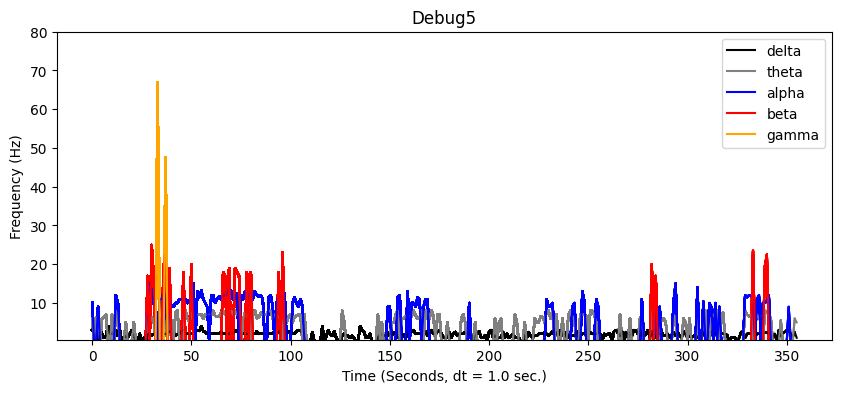

In [5]:
debug5_eeg.PlotPSDGantt(
  title="Debug5",
  fmin=0.5,
  fmax=80,
  figsize=(10,4),
  frequencies=["delta","theta","alpha","beta","gamma"],
  colors=["black","gray","blue","red","orange"],
  peak_threshold=50,
  representative_metric="mean",
  events=None,
  save_fig_filename=None,
)